In [61]:
import tensorflow as tf
import tensorflow_text as tf_text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [62]:
def load_data(path):
	with open('fra.txt','r') as f:
		lines = f.read().split('\n')[:-1]

	pairs = [line.split('\t') for line in lines]

	context = np.array([context for target, context in pairs])
	target = np.array([target for target, context in pairs])

	return target, context

In [63]:
target_raw, context_raw = load_data('fra.txt')

In [64]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
	tf.data.Dataset
	.from_tensor_slices((context_raw[is_train], target_raw[is_train]))
	.shuffle(BUFFER_SIZE)
	.batch(BATCH_SIZE))
val_raw = (
	tf.data.Dataset
	.from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
	.shuffle(BUFFER_SIZE)
	.batch(BATCH_SIZE))

In [65]:
for example_context_strings, example_target_strings in train_raw.take(1):
	print(example_context_strings[:5])
	print()
	print(example_target_strings[:5])
	print(example_context_strings.shape)
	break

tf.Tensor(
[b'Mary est belle et intelligente.'
 b"L'air est rare au sommet d'une haute montagne."
 b"Je pense qu'il vous faut maintenant partir."
 b"N'ouvrez pas votre livre !"
 b'Il est habitu\xc3\x83\xc2\xa9 \xc3\x83\xc2\xa0 parler en public.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Mary is beautiful and intelligent.'
 b'The air is thin at the top of a high mountain.'
 b'I think you need to leave now.' b"Don't open your book."
 b'He is used to speaking in public.'], shape=(5,), dtype=string)
(64,)


In [66]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [67]:
def tf_lower_and_split_punct(text):
	# Split accented characters.
	text = tf_text.normalize_utf8(text, 'NFKD')
	text = tf.strings.lower(text)
	# Keep space, a to z, and select punctuation.
	text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
	# Add spaces around punctuation.
	text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
	# Strip whitespace.
	text = tf.strings.strip(text)

	text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
	return text

In [68]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [69]:
max_vocab_size = 10000

context_text_processor = tf.keras.layers.TextVectorization(
	standardize=tf_lower_and_split_punct,
	max_tokens=max_vocab_size,
	ragged=True)

context_text_processor.adapt(train_raw.map(lambda context, target: context))

In [70]:
target_text_processor = tf.keras.layers.TextVectorization(
	standardize=tf_lower_and_split_punct,
	max_tokens=max_vocab_size,
	ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'i', 'you', 'to', 'the', '?']

In [71]:
example_tokens = context_text_processor(example_context_strings)
print(example_tokens[0])
print(example_context_strings[0])
print(example_tokens[2])
print(example_context_strings[2])

tf.Tensor([   2  104   18  449   53 1860    4    3], shape=(8,), dtype=int64)
tf.Tensor(b'Mary est belle et intelligente.', shape=(), dtype=string)
tf.Tensor([  2   5  69  52  14 138 147 221   4   3], shape=(10,), dtype=int64)
tf.Tensor(b"Je pense qu'il vous faut maintenant partir.", shape=(), dtype=string)


In [72]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] mary est belle et intelligente . [END]'

In [73]:
context_vocab.shape

(10000,)

Text(0.5, 1.0, 'Mask')

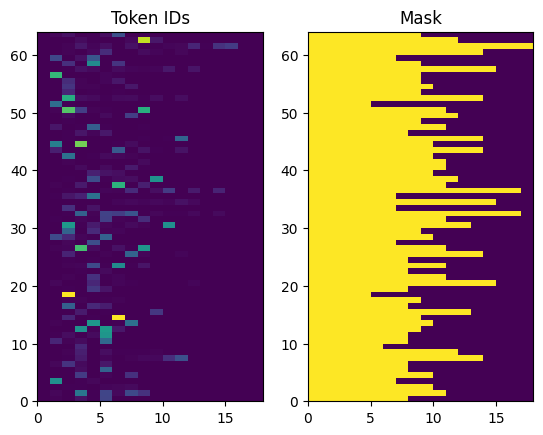

In [74]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [75]:
def process_text(context, target):
	context = context_text_processor(context).to_tensor()
	target = target_text_processor(target)
	targ_in = target[:,:-1].to_tensor()
	targ_out = target[:,1:].to_tensor()
	return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [76]:
for (ex_context_tok,ex_tar_in),ex_tar_out in train_ds.take(1):
	print(ex_context_tok[0,:].numpy())
	print(ex_context_tok.numpy().shape)
	print()
	print(ex_tar_in[0,:].numpy())
	print(ex_tar_in.numpy().shape)
	print(ex_tar_out[0,:].numpy())
	print(ex_tar_out.numpy().shape)

[   2   64   12 1717    7  100    6  633   44   62    4    3    0    0
    0    0    0]
(64, 17)

[   2   52   71  285 1618   39   49    4    0    0    0    0    0    0]
(64, 14)
[  52   71  285 1618   39   49    4    3    0    0    0    0    0    0]
(64, 14)


In [77]:
units = 256

In [78]:
class Encoder(tf.keras.layers.Layer):
	def __init__(self, text_processor, units,**kwargs):
		super(Encoder,self).__init__()
		self.text_processor = text_processor
		self.vocab_size = text_processor.vocabulary_size()
		self.units = units

		self.embedding = tf.keras.layers.Embedding(self.vocab_size,units,mask_zero=True)

		self.rnn = tf.keras.layers.Bidirectional(
			merge_mode='sum',
			layer=tf.keras.layers.GRU(units,
									  return_sequences=True,
									  recurrent_initializer='glorot_uniform')
		)
	
	def call(self, x):
		print(f"Encoder:")
		print(x.shape)
		x = self.embedding(x)
		print(f"Embedding")
		print(x.shape)
		x = self.rnn(x)
		print(f"RNN")
		print(x.shape)
		return x

	def convert_input(self,texts):
		texts = tf.convert_to_tensor(texts)
		if(len(texts))==0:
			texts = tf.convert_to_tensor(texts)[tf.newaxis]
		context = self.text_processor(texts).to_tensor()
		context = self(context)
		return context

In [79]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, units)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Encoder:
(64, 17)
Embedding
(64, 17, 256)
RNN
(64, 17, 256)
Context tokens, shape (batch, s): (64, 17)
Encoder output, shape (batch, s, units): (64, 17, 256)


In [80]:
class CrossAttention(tf.keras.layers.Layer):
	def __init__(self, units,**kwargs):
		super().__init__()
		self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units,num_heads=1,**kwargs)
		self.layernorm = tf.keras.layers.LayerNormalization()
		self.add = tf.keras.layers.Add()

	def call(self,x,context):
		print("CrossAttention")
		print('X (Key):',x.shape)
		print('Context (Value) :',context.shape)
		print()
		print()
		attn_output,attn_scores = self.mha(
			query = x,
			value = context,
			return_attention_scores = True
		)
		print(f"Attn_output :",attn_output.shape)
		print()
		print()
		attn_scores = tf.reduce_mean(attn_scores,axis=1) 
		self.last_attention_weights = attn_scores

		x = self.add([x,attn_output])
		print(f"Add",x.shape)
		print()
		print()
		x = self.layernorm(x)
		print(f"LayerNorm:")
		print(x.shape)
		return x

In [81]:
attention_layer = CrossAttention(units)
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),output_dim=units,mask_zero=True)
ex_tar_emb = embed(ex_tar_in)

result = attention_layer(ex_tar_emb,ex_context)

CrossAttention
X (Key): (64, 14, 256)
Context (Value) : (64, 17, 256)


Attn_output : (64, 14, 256)


Add (64, 14, 256)


LayerNorm:
(64, 14, 256)


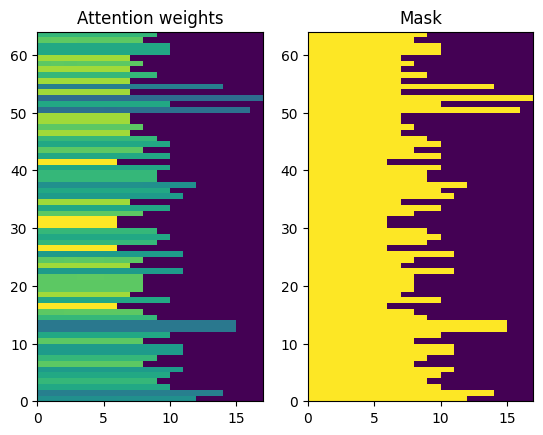

In [82]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [83]:
class Decoder(tf.keras.layers.Layer):  
		def __init__(self, text_processor,units):
				super().__init__()
				self.text_processor = text_processor
				self.units = units

				self.vocab_size = text_processor.vocabulary_size()

				self.word_to_id = tf.keras.layers.StringLookup(
				vocabulary=text_processor.get_vocabulary(),
				mask_token='', oov_token='[UNK]')
				self.id_to_word = tf.keras.layers.StringLookup(
						vocabulary=text_processor.get_vocabulary(),
						mask_token='', oov_token='[UNK]',
						invert=True)
				self.start_token = self.word_to_id('[START]')
				self.end_token = self.word_to_id('[END]')

				self.embedding = tf.keras.layers.Embedding(self.vocab_size,
																							 units, mask_zero=True)

				# 2. The RNN keeps track of what's been generated so far.
				self.rnn = tf.keras.layers.GRU(units,
																		return_sequences=True,
																		return_state=True,
																		recurrent_initializer='glorot_uniform')

				# 3. The RNN output will be the query for the attention layer.
				self.attention = CrossAttention(units)

				# 4. This fully connected layer produces the logits for each
				# output token.
				self.output_layer = tf.keras.layers.Dense(self.vocab_size)

				
		def call(self,context,x,state=None,return_state = False):
				print("Decoder :")
				print('x:',x.shape)
				print('context : ',context.shape)
				print()
				print()
				
				x = self.embedding(x)
				print(f"Embedding")
				print(x.shape)
				print()
				print()

				x,state = self.rnn(x,initial_state = state)
				print(f"RNN")
				print(x.shape)
				print()
				print()

				x = self.attention(x,context)
				print("SelfAttention:")
				print("X : ",x.shape)
				print()
				print()

				self.last_attention_weights = self.attention.last_attention_weights

				logits = self.output_layer(x)
				print()
				print()
				print("Output(Dense): ",logits.shape)

				if return_state:
						return logits,state
				
				else:   
						return logits
				
		def get_initial_state(self, context):
			batch_size = tf.shape(context)[0]
			start_tokens = tf.fill([batch_size, 1], self.start_token)
			done = tf.zeros([batch_size, 1], dtype=tf.bool)
			embedded = self.embedding(start_tokens)
			return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

		def tokens_to_text(self, tokens):
			words = self.id_to_word(tokens)
			result = tf.strings.reduce_join(words, axis=-1, separator=' ')
			result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
			result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
			return result

		def get_next_token(self, context, next_token, done, state, temperature = 0.0):
			logits, state = self(
				context, next_token,
				state = state,
				return_state=True) 

			if temperature == 0.0:
				next_token = tf.argmax(logits, axis=-1)
			else:
				logits = logits[:, -1, :]/temperature
				next_token = tf.random.categorical(logits, num_samples=1)

			# If a sequence produces an `end_token`, set it `done`
			done = done | (next_token == self.end_token)
			# Once a sequence is done it only produces 0-padding.
			next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

			return next_token, done, state
				

In [84]:
decoder  = Decoder(target_text_processor,units)

logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

Decoder :
x: (64, 14)
context :  (64, 17, 256)


Embedding
(64, 14, 256)


RNN
(64, 14, 256)


CrossAttention
X (Key): (64, 14, 256)
Context (Value) : (64, 17, 256)


Attn_output : (64, 14, 256)


Add (64, 14, 256)


LayerNorm:
(64, 14, 256)
SelfAttention:
X :  (64, 14, 256)




Output(Dense):  (64, 14, 10000)
encoder output shape: (batch, s, units) (64, 17, 256)
input target tokens shape: (batch, t) (64, 14)
logits shape shape: (batch, target_vocabulary_size) (64, 14, 10000)


In [85]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
	# Run one step.
	next_token, done, state = decoder.get_next_token(
			ex_context, next_token, done, state, temperature=1.0)
	# Add the token to the output.
	tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:5].numpy()

Decoder :
x: (64, 1)
context :  (64, 17, 256)


Embedding
(64, 1, 256)


RNN
(64, 1, 256)


CrossAttention
X (Key): (64, 1, 256)
Context (Value) : (64, 17, 256)


Attn_output : (64, 1, 256)


Add (64, 1, 256)


LayerNorm:
(64, 1, 256)
SelfAttention:
X :  (64, 1, 256)




Output(Dense):  (64, 1, 10000)
Decoder :
x: (64, 1)
context :  (64, 17, 256)


Embedding
(64, 1, 256)


RNN
(64, 1, 256)


CrossAttention
X (Key): (64, 1, 256)
Context (Value) : (64, 17, 256)


Attn_output : (64, 1, 256)


Add (64, 1, 256)


LayerNorm:
(64, 1, 256)
SelfAttention:
X :  (64, 1, 256)




Output(Dense):  (64, 1, 10000)
Decoder :
x: (64, 1)
context :  (64, 17, 256)


Embedding
(64, 1, 256)


RNN
(64, 1, 256)


CrossAttention
X (Key): (64, 1, 256)
Context (Value) : (64, 17, 256)


Attn_output : (64, 1, 256)


Add (64, 1, 256)


LayerNorm:
(64, 1, 256)
SelfAttention:
X :  (64, 1, 256)




Output(Dense):  (64, 1, 10000)
Decoder :
x: (64, 1)
context :  (64, 17, 256)


Embedding
(64, 1, 256)


RNN
(64, 1, 256)



array([b'suitcase miss taught dripping duty opens foot prides myth cartridge',
       b'invincible challenge drafting grammar doctors fine passage puts workers squabbling',
       b'great shocks badge spirits bottom dove football thinking past hours',
       b'here milk irresponsible slammed salmon continuing applies zoos decreasing silly',
       b'preaching tidier tide blanket suffers derogatory despite flattered cupboard admire'],
      dtype=object)

In [86]:
class Translator(tf.keras.Model):
		def __init__(self,units, context_text_processor,target_text_processor):
				super().__init__()

				encoder = Encoder(context_text_processor,units)
				decoder = Decoder(target_text_processor,units)

				self.encoder = encoder
				self.decoder = decoder


		def call(self,inputs):
			print("Translator: ")
			context,x = inputs
			print('x:',x.shape)
			print('context : ',context.shape)
			print()
			print()
			print()

			context = self.encoder(context)
			print("Encoder Output(Context): ",context.shape)
			print()
			print()
			print()

			logits = self.decoder(context,x)
			print("Decoder Output(Logits): ",logits.shape)
			
			try:
					del logits._keras_mask
			except AttributeError:
					pass
			
			return logits
				
		def translate(self,
									texts, *,
									max_length=50,
									temperature=0.0):
			# Process the input texts
			context = self.encoder.convert_input(texts)
			batch_size = tf.shape(texts)[0]

			# Setup the loop inputs
			tokens = []
			attention_weights = []
			next_token, done, state = self.decoder.get_initial_state(context)

			for _ in range(max_length):
				# Generate the next token
				next_token, done, state = self.decoder.get_next_token(
						context, next_token, done,  state, temperature)

				# Collect the generated tokens
				tokens.append(next_token)
				attention_weights.append(self.decoder.last_attention_weights)

				if tf.executing_eagerly() and tf.reduce_all(done):
					break

			# Stack the lists of tokens and attention weights.
			tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
			self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

			result = self.decoder.tokens_to_text(tokens)
			return result

In [87]:
model =  Translator(units,context_text_processor,target_text_processor)

print("(ex_context_tok,ex_tar_in)")
logits = model((ex_context_tok,ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

(ex_context_tok,ex_tar_in)
Translator: 
x: (64, 14)
context :  (64, 17)



Encoder:
(64, 17)
Embedding
(64, 17, 256)
RNN
(64, 17, 256)
Encoder Output(Context):  (64, 17, 256)



Decoder :
x: (64, 14)
context :  (64, 17, 256)


Embedding
(64, 14, 256)


RNN
(64, 14, 256)


CrossAttention
X (Key): (64, 14, 256)
Context (Value) : (64, 17, 256)


Attn_output : (64, 14, 256)


Add (64, 14, 256)


LayerNorm:
(64, 14, 256)
SelfAttention:
X :  (64, 14, 256)




Output(Dense):  (64, 14, 10000)
Decoder Output(Logits):  (64, 14, 10000)
Context tokens, shape: (batch, s, units) (64, 17)
Target tokens, shape: (batch, t) (64, 14)
logits, shape: (batch, t, target_vocabulary_size) (64, 14, 10000)


In [88]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [89]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [90]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

model.evaluate(val_ds, steps=20, return_dict=True)

Translator: 
x: (None, None)
context :  (None, None)



Encoder:
(None, None)
Embedding
(None, None, 256)
RNN
(None, None, 256)
Encoder Output(Context):  (None, None, 256)



Decoder :
x: (None, None)
context :  (None, None, 256)


Embedding
(None, None, 256)


RNN
(None, None, 256)


CrossAttention
X (Key): (None, None, 256)
Context (Value) : (None, None, 256)


Attn_output : (None, None, 256)


Add (None, None, 256)


LayerNorm:
(None, None, 256)
SelfAttention:
X :  (None, None, 256)




Output(Dense):  (None, None, 10000)
Decoder Output(Logits):  (None, None, 10000)
Translator: 
x: (None, None)
context :  (None, None)



Encoder:
(None, None)
Embedding
(None, None, 256)
RNN
(None, None, 256)
Encoder Output(Context):  (None, None, 256)



Decoder :
x: (None, None)
context :  (None, None, 256)


Embedding
(None, None, 256)


RNN
(None, None, 256)


CrossAttention
X (Key): (None, None, 256)
Context (Value) : (None, None, 256)


Attn_output : (None, None, 256)


Add (None, None, 256)




{'loss': 9.218413352966309,
 'masked_acc': 0.0,
 'masked_loss': 9.218413352966309}

In [91]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
Translator: 
x: (None, None)
context :  (None, None)



Encoder:
(None, None)
Embedding
(None, None, 256)
RNN
(None, None, 256)
Encoder Output(Context):  (None, None, 256)



Decoder :
x: (None, None)
context :  (None, None, 256)


Embedding
(None, None, 256)


RNN
(None, None, 256)


CrossAttention
X (Key): (None, None, 256)
Context (Value) : (None, None, 256)


Attn_output : (None, None, 256)


Add (None, None, 256)


LayerNorm:
(None, None, 256)
SelfAttention:
X :  (None, None, 256)




Output(Dense):  (None, None, 10000)
Decoder Output(Logits):  (None, None, 10000)
Translator: 
x: (None, None)
context :  (None, None)



Encoder:
(None, None)
Embedding
(None, None, 256)
RNN
(None, None, 256)
Encoder Output(Context):  (None, None, 256)



Decoder :
x: (None, None)
context :  (None, None, 256)


Embedding
(None, None, 256)


RNN
(None, None, 256)


CrossAttention
X (Key): (None, None, 256)
Context (Value) : (None, None, 256)


Attn_output : (None, None, 256)


Add (None, N

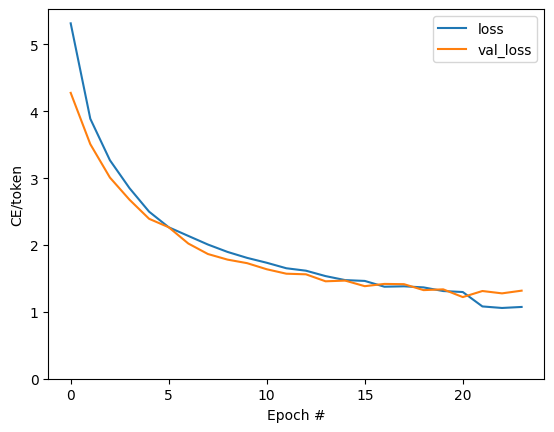

In [92]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

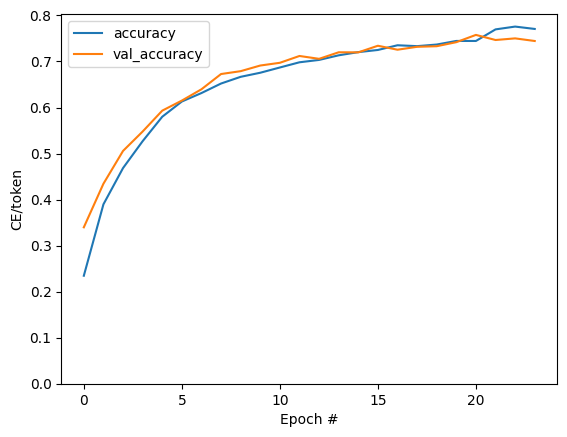

In [93]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [106]:
result = model.translate(['C’est un jour merveilleux']) # Are you still home

Encoder:
(1, 6)
Embedding
(1, 6, 256)
RNN
(1, 6, 256)
Decoder :
x: (1, 1)
context :  (1, 6, 256)


Embedding
(1, 1, 256)


RNN
(1, 1, 256)


CrossAttention
X (Key): (1, 1, 256)
Context (Value) : (1, 6, 256)


Attn_output : (1, 1, 256)


Add (1, 1, 256)


LayerNorm:
(1, 1, 256)
SelfAttention:
X :  (1, 1, 256)




Output(Dense):  (1, 1, 10000)
Decoder :
x: (1, 1)
context :  (1, 6, 256)


Embedding
(1, 1, 256)


RNN
(1, 1, 256)


CrossAttention
X (Key): (1, 1, 256)
Context (Value) : (1, 6, 256)


Attn_output : (1, 1, 256)


Add (1, 1, 256)


LayerNorm:
(1, 1, 256)
SelfAttention:
X :  (1, 1, 256)




Output(Dense):  (1, 1, 10000)
Decoder :
x: (1, 1)
context :  (1, 6, 256)


Embedding
(1, 1, 256)


RNN
(1, 1, 256)


CrossAttention
X (Key): (1, 1, 256)
Context (Value) : (1, 6, 256)


Attn_output : (1, 1, 256)


Add (1, 1, 256)


LayerNorm:
(1, 1, 256)
SelfAttention:
X :  (1, 1, 256)




Output(Dense):  (1, 1, 10000)
Decoder :
x: (1, 1)
context :  (1, 6, 256)


Embedding
(1, 1, 256)


RNN
(1,

In [107]:
result[0].numpy().decode()

'this is a wonderful day . '